In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import scipy
from scipy import signal as ss

from ee102b_utilities import *

## Load and Visualize Data

In [3]:
# open the data file, inspect data fields
ds = xr.open_dataset("radar_noisy_firsthalf.nc")
ds

<xarray.Dataset>
Dimensions:               (fast_time: 3200, slow_time: 2500)
Coordinates:
  * fast_time             (fast_time) float64 0.0 2e-08 ... 6.396e-05 6.398e-05
  * slow_time             (slow_time) float64 0.0 0.05128 0.1026 ... 128.1 128.2
Data variables:
    reference_chirp_real  (fast_time) float64 ...
    reference_chirp_imag  (fast_time) float64 ...
    data                  (slow_time, fast_time) int32 ...
    bed_pick              (slow_time) int64 ...
Attributes:
    fs:       50000000.0
    prf:      19.5

Unfiltered Average SNR = 26.65 dB


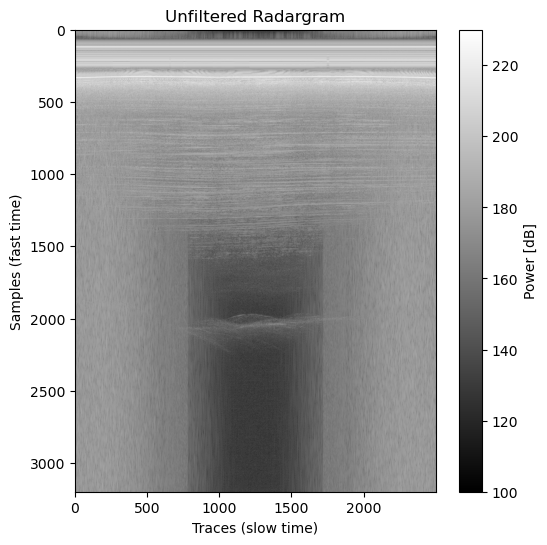

In [55]:
# view unfiltered radargram
pulse_compressed = pulse_compress(ds)
pulse_compressed_unfiltered = pulse_compressed
plot_radargram(pulse_compressed, title="Unfiltered Radargram")

snr_unfiltered, snr_avg_unfiltered = estimate_snr(pulse_compressed, ds["bed_pick"])
snr_avg_unfiltered = 10*np.log10(snr_avg_unfiltered)
print('Unfiltered Average SNR = %.2f dB' % snr_avg_unfiltered)

It's hard to see the bed reflection throughout this radargram and there's clearly some noise corrupting the data. The average SNR is okay, but SNR alone doesn't mean much if we can't see the bed. 

## Try a Simple Lowpass Filter

We know the bandwidth of the radar system is 15 MHz, so a reasonable initial guess might be that our signal will be contained entirely in the 0-15 MHz range. Let's implement a lowpass filter with a cutoff frequency of 15 MHz and apply it to the radargram to see if we can reduce some of this noise and improve the SNR and interprebility of our data.  

In [5]:
# build simple lowpass filter
lowpass_filter = scipy.signal.butter(4, 15e6, btype='lowpass', output='sos', fs=ds.fs)

# nyquist_freq = ds.fs / 2
# # cutoff_freq = [0, 8]  # Hz
# #     order = 4

# # Calculate filter coefficients
# b, a = scipy.signal.butter(4, [0.5 / nyquist_freq, 8 / nyquist_freq], btype='band')

    
data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 26.15 dB


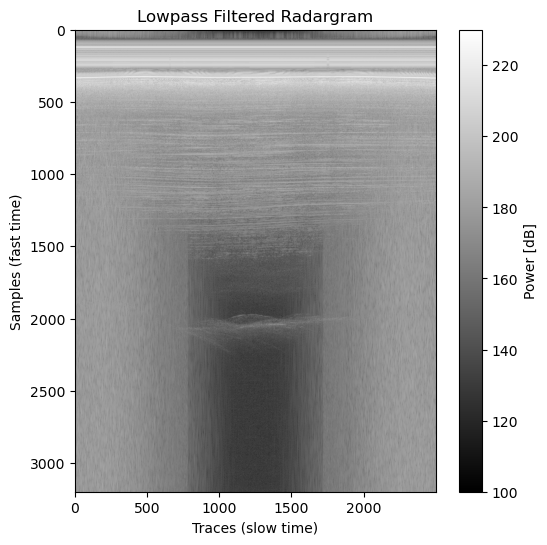

In [6]:
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    trace_filtered = scipy.signal.sosfilt(lowpass_filter, trace_unfiltered)
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

Hmmm. That didn't really do much. You'll have to get fancier and look at the noise characteristics and design filters specific to that. Happy filtering!

## Investigate Noise Characteristics, Design & Apply Filters

In [7]:
# look at noise characteristics (e.g. compute spectrogram) fill in TODOs in framework below

In [8]:
plot_spectrogram(signal=ds["data"].to_numpy(), window_type="chebwin", fs=ds.fs)

NameError: name 'plot_spectrogram' is not defined

In [ ]:

def plot_spectrogram(signal, window_type="hann", fs=None):
    nfasttime = np.shape(signal)[0]
    nslowtime = np.shape(signal)[1]
    
    #scipy.signal.gaussian(3200,90)
    #scipy.signal.kaiser(3200,150)
    #scipy.signal.chebwin(3200,4000)
    
    signal = signal.flatten()
    
    if window_type == "hann":
        window = scipy.signal.hann(3200)
    elif window_type == "hamming":
        window = scipy.signal.hamming(3200)
    elif window_type == "hamm":
        window = scipy.signal.hamm(3200)
    elif window_type == "rect":
        window = np.ones(3200)
    elif window_type == "gaussian":
        window = scipy.signal.gaussian(3200,90)
    elif window_type == "kaiser":
        window = scipy.signal.kaiser(3200,150)
    elif window_type == "chebwin":
        window = scipy.signal.chebwin(3200,4000)
    else:
        window = scipy.signal.hamming(3200)
        
    spectrogram_options = {
    "fs": fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 0,
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
    }
    
    f, t, Sxx_test = scipy.signal.spectrogram(signal, **spectrogram_options)
    print(np.shape(Sxx_test))
    fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
    p = plt.pcolormesh(np.arange(len(ds["slow_time"])), f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
    #p = plt.pcolormesh(t, f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
    x_pts = np.arange(2500)
    y1=0.0000038320*x_pts**2-0.0096107*x_pts+9.05744
    y2=0.0000039139*x_pts**2-0.0098156*x_pts+7.2131
    c = plt.plot(x_pts, y1, y2, color='r')
    clb = fig.colorbar(p, ax=ax)
    clb.set_label('Power Spectral Density [dB/Hz]')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [MHz]')
    plt.show()
    return

In [ ]:
# apply filters that address the noise you see in the radargram (see above for example filter application if needed)
# use the visual quality of the radargram and the SNR as metrics for how well you are doing

In [ ]:
# build filter
#lowpass_filter = scipy.signal.ellip(4, 1, 80, 15e6, btype='lowpass', output='sos', fs=ds.fs)
lowpass_filter = scipy.signal.butter(5, 15e6, btype='lowpass', output='sos', fs=ds.fs)

nyq = 0.5 * ds.fs
low = 2E6 / nyq
high = 8E6 / nyq
        
stopband_filter = scipy.signal.butter(5, [low, high], btype='bandstop', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 36.32 dB


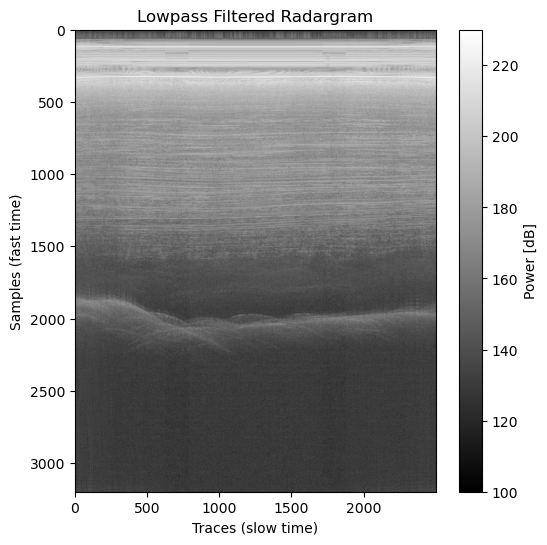

In [62]:
raw_output = np.empty(np.shape(data_out))
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    #Apply a Hann Window
    hann_window = ss.hann(len(trace_unfiltered))
    hamming_window = ss.hamming(len(trace_unfiltered))
    windowed_signal = trace_unfiltered #* hann_window 
    # for i in range (1,15):
    #     windowed_signal = windowed_signal * hann_window
    # windowed_signal = windowed_signal *hamming_window 


    #mouth filter
    high=(0.0000038320*idx**2-0.0096107*idx+9.05744)*1E6
    low=(0.0000039139*idx**2-0.0098156*idx+7.2131)*1E6
    mouth_filt = ss.butter(30, [low, high], btype='bandstop', output='sos', fs=ds.fs)
    
    trace_filtered1 = scipy.signal.sosfiltfilt(mouth_filt, windowed_signal)
    
    #eyes
    if (623 <= idx <= 785) or (1715 <= idx <= 1875):
        low2 = 12E6
        high2 = 17.5E6
        eye_filt = ss.butter(20, low2, btype='lowpass', output='sos', fs=ds.fs)
        
        trace_filtered1 = scipy.signal.sosfiltfilt(eye_filt, trace_filtered1)
        trace_filtered1 = scipy.signal.sosfiltfilt(eye_filt, trace_filtered1)

    
    raw_output[idx,:] = (trace_filtered1)
    pulse_compressed = pulse_compress_one_trace(trace_filtered1, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

In [10]:
plot_spectrogram(signal=raw_output, window_type="gaussian", fs=ds.fs)

NameError: name 'plot_spectrogram' is not defined

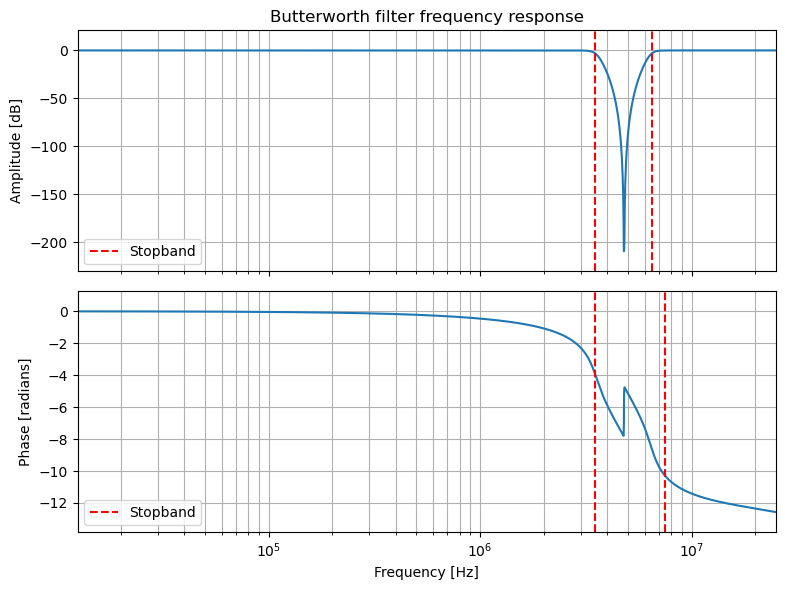

In [40]:
nyquist_freq = 0.5 * ds.fs
low_cutoff = 3.5E6 / nyquist_freq
high_cutoff = 6.5E6 / nyquist_freq

b, a = ss.butter(5, [low_cutoff, high_cutoff], btype='bandstop')
                 
w, h = ss.freqz(b, a, worN=2000)
 
frequencies = (w / (2*np.pi)) * ds.fs

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Amplitude response plot
ax1.semilogx(frequencies, 20 * np.log10(abs(h)))
ax1.set_title('Butterworth filter frequency response')
ax1.set_ylabel('Amplitude [dB]')
ax1.margins(0, 0.1)
ax1.grid(which='both', axis='both')
ax1.axvline(3.5E6, color='red', linestyle='--', label='Stopband')
ax1.axvline(6.5E6, color='red', linestyle='--')
ax1.legend()

# Phase response plot
phase = np.unwrap(np.angle(h))
ax2.semilogx(frequencies, phase)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase [radians]')
ax2.margins(0, 0.1)
ax2.grid(which='both', axis='both')
ax2.axvline(3.5E6, color='red', linestyle='--', label='Stopband')
ax2.axvline(7.5E6, color='red', linestyle='--')
ax2.legend()

plt.tight_layout()
plt.show()


In [41]:
def plot_window_spectra(window, fs, nfft=1024, title=""):
    """
    Plot the frequency response of a window in dB
    """
    f, Pxx = ss.welch(window, fs=fs, nfft=nfft)
    plt.plot(f, 10*np.log10(Pxx))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power Spectral Density [dB/Hz]")
    plt.title(title)
    plt.show()
    return

/Users/rohansanda/opt/miniconda3/envs/ee102b_project/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


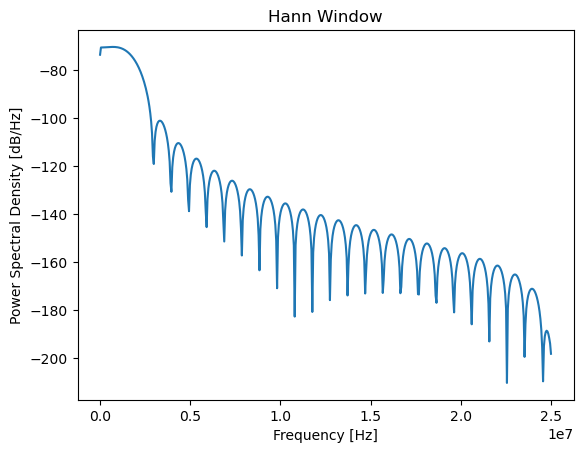

In [43]:
plot_window_spectra(window=ss.hann(51), fs=ds.fs, title="Hann Window")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

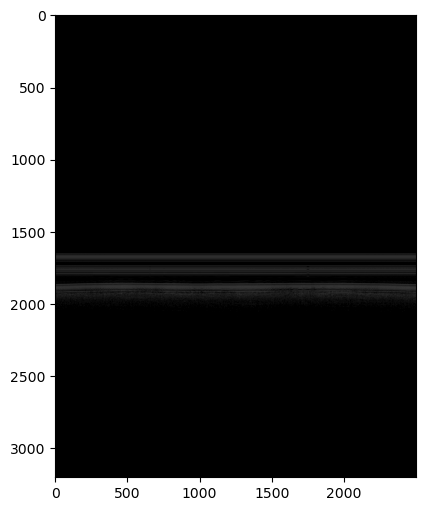

In [30]:
data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)

# Apply matched filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx, :]
    
    # Normalize the reference chirp
    ref_chirp /= np.linalg.norm(ref_chirp)
    
    # Apply matched filter
    trace_filtered = signal.correlate(trace_unfiltered, ref_chirp, mode='same')
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20 * np.log10(np.abs(pulse_compressed)))

plot_radargram(data_out, title="Matched Filtered Radargram", bed_x=np.arange(len(ds["slow_time"])), bed_y=ds["bed_pick"])

snr_matched, snr_avg_matched = estimate_snr(data_out, ds["bed_pick"])
snr_avg_matched = 10 * np.log10(snr_avg_matched)
print('Matched Filtered Average SNR = %.2f dB' % snr_avg_matched)

Before Wavelet Average SNR = 36.32 dB
After Wavelet Average SNR = 38.80 dB


(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': 'Denoised Radargram'}, xlabel='Traces (slow time)', ylabel='Samples (fast time)'>)

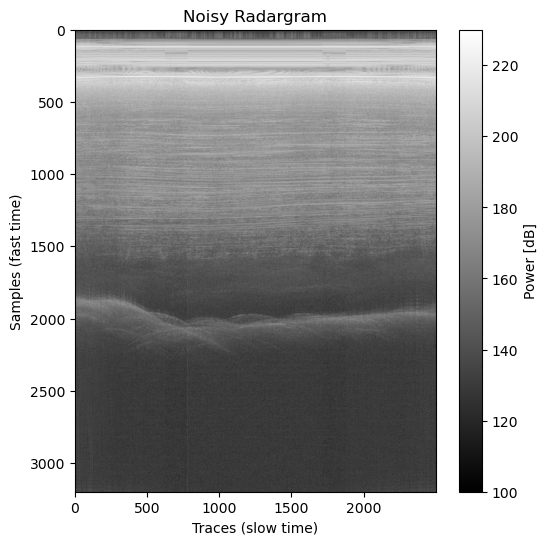

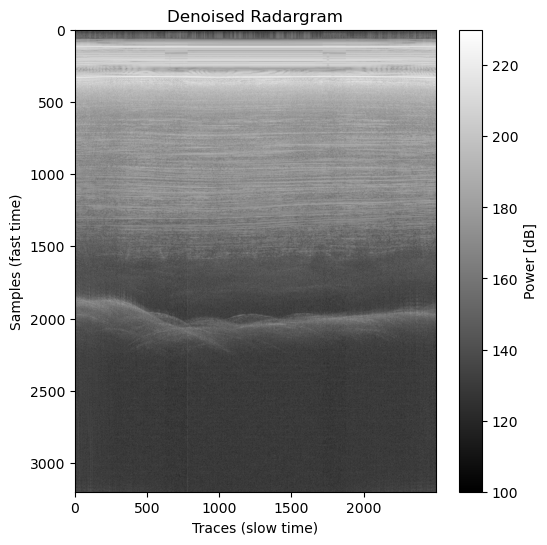

In [45]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Define the wavelet denoising function for 2D radargram
def wavelet_denoising_2d(radargram, wavelet='db6', level=1, mode='soft'):
    denoised_radargram = np.zeros_like(radargram)
    std = 0.6745
    
    # Apply wavelet denoising to each row
    for i in range(radargram.shape[0]):
        row = radargram[i, :]
        coeffs = pywt.wavedec(row, wavelet, level=level)
        
        # Estimate the noise level based on the standard deviation
        sigma = np.median(np.abs(coeffs[-level])) / std
        
        # Apply thresholding to the wavelet coefficients
        denoised_coeffs = [pywt.threshold(coeff, value=sigma, mode=mode) for coeff in coeffs]
        
        # Reconstruct the denoised row
        denoised_row = pywt.waverec(denoised_coeffs, wavelet)
        denoised_radargram[i, :] = denoised_row

    # Apply wavelet denoising to each column
    for j in range(denoised_radargram.shape[1]):
        col = denoised_radargram[:, j]
        coeffs = pywt.wavedec(col, wavelet, level=level)
        
        # Estimate the noise level based on the standard deviation
        sigma = np.median(np.abs(coeffs[-level])) / std
        
        # Apply thresholding to the wavelet coefficients
        denoised_coeffs = [pywt.threshold(coeff, value=sigma, mode=mode) for coeff in coeffs]
        
        # Reconstruct the denoised column
        denoised_col = pywt.waverec(denoised_coeffs, wavelet)
        denoised_radargram[:, j] = denoised_col

    return denoised_radargram

icesheet_radargram = data_out.T # np.random.rand(100, 200) 

snr_before, snr_avg_before = estimate_snr(data_out, ds["bed_pick"])
snr_avg_before = 10*np.log10(snr_avg_before)
print('Before Wavelet Average SNR = %.2f dB' % snr_avg_before)

# Apply wavelet denoising to the icesheet radargram
denoised_radargram = wavelet_denoising_2d(icesheet_radargram, wavelet='coif1', level=2, mode='garotte')

snr_after, snr_avg_after = estimate_snr(denoised_radargram.T, ds["bed_pick"])
snr_avg_after = 10*np.log10(snr_avg_after)
print('After Wavelet Average SNR = %.2f dB' % snr_avg_after)


# Plotting the results
plot_radargram(icesheet_radargram.T, title="Noisy Radargram")
plot_radargram(denoised_radargram.T, title="Denoised Radargram")


In [61]:
np.set_printoptions(None)

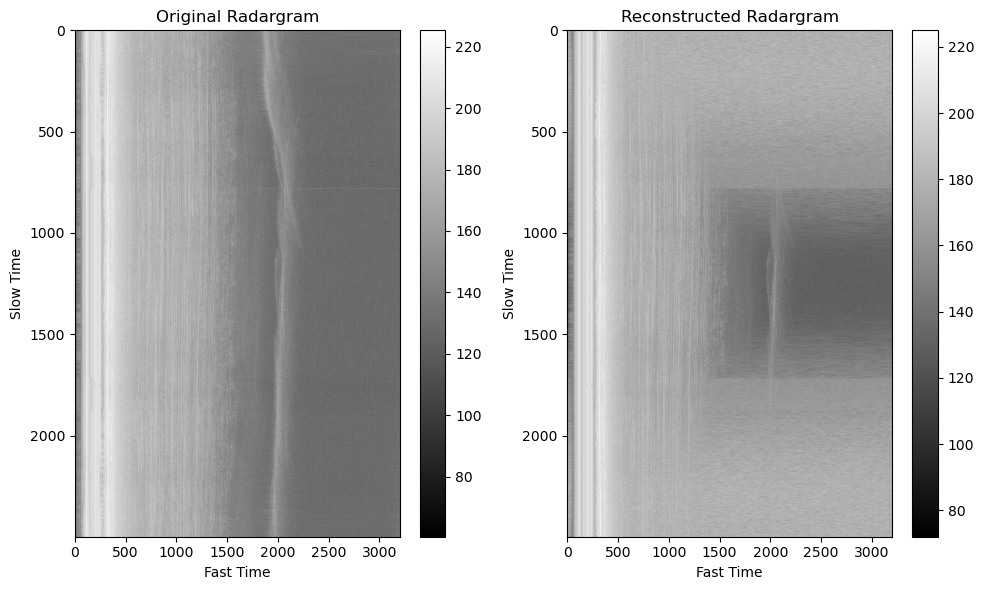

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_filtered_radargram(radargram, filtered_radargram):
    # Find the indices where the filtered radargram is zero (indicating filtered regions)
    zero_indices = np.where(filtered_radargram == 0)

    # Transpose the arrays for interpolation along the slow time axis
    radargram_t = radargram.T
    filtered_radargram_t = filtered_radargram.T

    # Interpolate the values using linear interpolation
    interpolated_radargram_t = np.copy(filtered_radargram_t)
    for i in range(filtered_radargram_t.shape[0]):
        row = filtered_radargram_t[i, :]
        nonzero_indices = np.nonzero(row)[0]
        if len(nonzero_indices) > 0:
            interpolated_radargram_t[i, zero_indices[0]] = np.interp(
                zero_indices[0], nonzero_indices, row[nonzero_indices]
            )

    # Transpose the interpolated radargram back to its original shape
    interpolated_radargram = interpolated_radargram_t.T

    # Replace the zero values in the original radargram with the interpolated values
    reconstructed_radargram = np.copy(radargram)
    reconstructed_radargram[zero_indices] = interpolated_radargram[zero_indices]

    return reconstructed_radargram

# Load your filtered radargram data here or generate it using your preferred method
# Replace the following lines with your own data loading or generation code
# radargram = np.random.rand(100, 200)  # Example radargram data
# filtered_radargram = np.copy(radargram)
# filtered_radargram[20:40, :] = 0  # Simulating filtered regions

filtered_radargram = data_out.T


# Reconstruct the filtered radargram
reconstructed_radargram = reconstruct_filtered_radargram(pulse_compressed_unfiltered, filtered_radargram)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(data_out, cmap='gray', aspect='auto')
plt.title('Original Radargram')
plt.xlabel('Fast Time')
plt.ylabel('Slow Time')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_radargram, cmap='gray', aspect='auto')
plt.title('Reconstructed Radargram')
plt.xlabel('Fast Time')
plt.ylabel('Slow Time')
plt.colorbar()

plt.tight_layout()
plt.show()


3200
3200


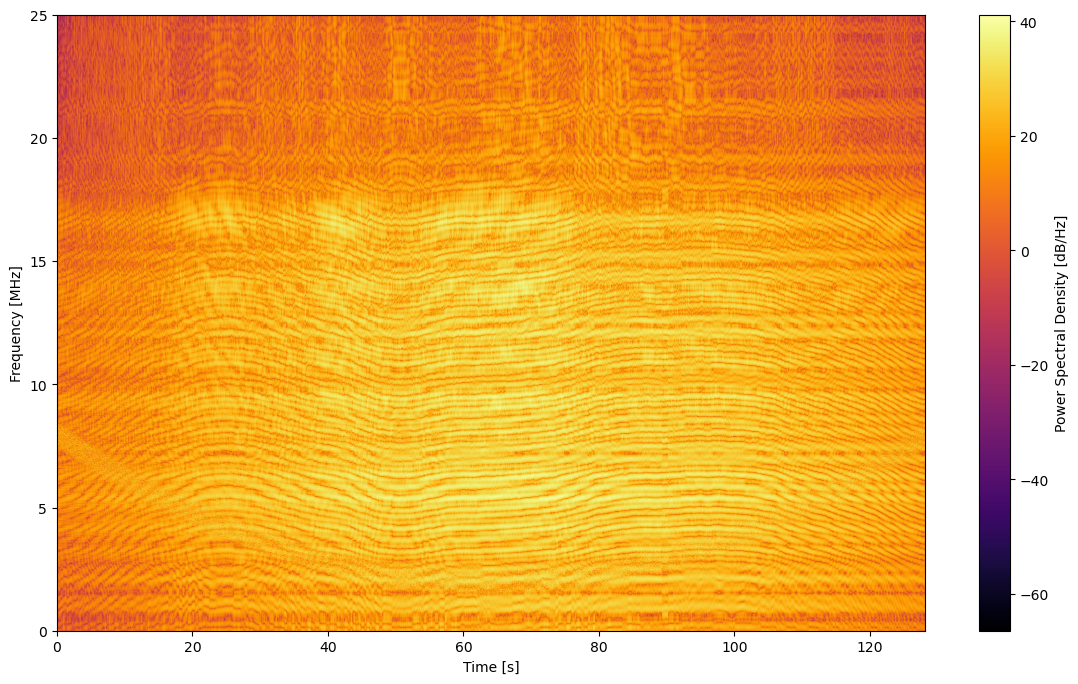

In [14]:
window = scipy.signal.hamming(3200)
#scipy.signal.gaussian(3200,90)
#scipy.signal.kaiser(3200,150)
#scipy.signal.chebwin(3200,4000)

print(len(window))
print(len(ds.fast_time))

spectrogram_options = {
    "fs": ds.fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 1,
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}
f, t, Sxx_test = scipy.signal.spectrogram(ds["data"].to_numpy().flatten(), **spectrogram_options)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
p = plt.pcolormesh(ds["slow_time"], f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
clb = fig.colorbar(p, ax=ax)
clb.set_label('Power Spectral Density [dB/Hz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [MHz]')
plt.show()